# EfficientNet B0 + Transfer learning
This jupyter notebook explores the performance of a pretrained efficientnet B0 model on the chest X-ray Pneumonia dataset.

We will use the efficientnet_b0 model from torchvision.models. The model is pretrained on the ImageNet dataset. The final layer of the model is modified to match the binary output of our Pneumonia classifier. The first layer is modified to work with grayscale images. We will first train the model for a warm-up period where the intermediate layers of the model are frozen. Then the deeper layers of the model are unfrozen. 

## Import required libraries

In [1]:
import os
import sys
import torch
from torchinfo import summary
module_path = os.path.abspath(os.path.join('..')) # project root
# add project root to sys.path
if module_path not in sys.path:
    sys.path.append(module_path) 
from src.data_loader import get_dataloader
from src.transforms import get_transforms
from src.models import efficientnet
from src.models.utils import unfreeze_layers, get_optimizer
from src.train import train_model
from src.evaluate import evaluate_model
from src.plot_metrics import plot_learningcurve, plot_confusionmatrix, plot_learningrate

## Configuration

In [2]:
data_dir = "../data/raw/chest_xray"
batch_size = 32
epochs = 5
learning_rate = 1e-3 # 
img_size = 224 #
n_channels = 1 

# get device for training
#device  = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load data
The training data is augmented to improve performance and balanced through resampling. For this model, we will convert the 1-channel grayscale images to 3-channel images, as EfficientNet expects 3-channel RGB input. The grayscale channel is repeated 3 times to match this expectation. By doing this, we do not have to replace the first conv layer in the model and can use the pretrained weights.

In [3]:
# augment and balance the data, convert to 3-channel grayscale 

train_transform = get_transforms(img_size,to_rgb=True,augment=True)
val_transform = get_transforms(img_size,to_rgb=True, augment=False)
# set num_workers to 0, safer on Windows with CPU
train_dataloader = get_dataloader(os.path.join(data_dir,'train'), batch_size=batch_size, num_workers=0,transform=train_transform,balance=True)
val_dataloader = get_dataloader(os.path.join(data_dir,'val'), batch_size=batch_size, num_workers=0,transform=val_transform)
test_dataloader = get_dataloader(os.path.join(data_dir,'test'), batch_size=batch_size, num_workers=0,transform=val_transform)

## Efficientnet B0 model (gradual unfreezing)
Use a pre-trained EfficientnetB0 model (trained on ImageNet dataset) and initially freeze all layers except the final classification head. After a few epochs, fine-tune the model further by unfreezing some of the deeper layers, and continue training at a lower learning rate.

### Model Setup


In [5]:
model_efficientnet_freeze = efficientnet.get_efficientnetB0(pretrained=True, freeze=True).to(device)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

head_params = [
    {'params': model_efficientnet_freeze.classifier.parameters(),'lr': learning_rate}
    ]
#optimizer with weightdecay
# use AdamW optimizer as it decouples weight decay from gradient update, leading to more consistent regularization and better generalization than the Adam optimizer
optimizer = torch.optim.AdamW(head_params, weight_decay=1e-4)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# print the model summary
summary(model_efficientnet_freeze,input_size=[batch_size,3,img_size,img_size])

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 1]                   --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

### Train model (warm-up stage)

In [6]:
metrics_history_efficientnet_warmup = train_model(model_efficientnet_freeze,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs=epochs,scheduler=scheduler)

 Epoch 1 / 5:


Training: 100%|██████████| 163/163 [09:08<00:00,  3.36s/it]


  Average train loss:0.364046  
 Accuracy on the train dataset: 87.94%


Validation: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


  Average val loss:0.339492  
 Accuracy on the validation dataset: 86.54%
 Epoch 2 / 5:


Training: 100%|██████████| 163/163 [09:05<00:00,  3.35s/it]


  Average train loss:0.236253  
 Accuracy on the train dataset: 91.83%


Validation: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


  Average val loss:0.306043  
 Accuracy on the validation dataset: 88.46%
 Epoch 3 / 5:


Training: 100%|██████████| 163/163 [08:53<00:00,  3.27s/it]


  Average train loss:0.201197  
 Accuracy on the train dataset: 92.79%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.20s/it]


  Average val loss:0.291465  
 Accuracy on the validation dataset: 88.94%
 Epoch 4 / 5:


Training: 100%|██████████| 163/163 [07:52<00:00,  2.90s/it]


  Average train loss:0.187476  
 Accuracy on the train dataset: 93.40%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


  Average val loss:0.290710  
 Accuracy on the validation dataset: 89.10%
 Epoch 5 / 5:


Training: 100%|██████████| 163/163 [07:52<00:00,  2.90s/it]


  Average train loss:0.190014  
 Accuracy on the train dataset: 93.31%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

  Average val loss:0.290231  
 Accuracy on the validation dataset: 89.58%
Done!


### Train Model (gradual unfreeze)
Unfreeze the last 2 blocks and train for 5 epochs

In [7]:
# unfreeze the last two blocks
unfreeze_layers(model_efficientnet_freeze, [6,7], prefix='features')

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()
# optimzer
optimizer = get_optimizer(model_efficientnet_freeze, backbone_lr=1e-4, head_lr=1e-3,backbone_prefixes=('features'), head_prefixes=('classifier',),weight_decay=1e-4)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

metrics_history_efficientnet_unfreeze = train_model(model_efficientnet_freeze,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs=epochs,scheduler=scheduler)

 Epoch 1 / 5:


Training: 100%|██████████| 163/163 [10:35<00:00,  3.90s/it]


  Average train loss:0.124497  
 Accuracy on the train dataset: 95.34%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


  Average val loss:0.277205  
 Accuracy on the validation dataset: 89.42%
 Epoch 2 / 5:


Training: 100%|██████████| 163/163 [08:51<00:00,  3.26s/it]


  Average train loss:0.089616  
 Accuracy on the train dataset: 96.88%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


  Average val loss:0.275941  
 Accuracy on the validation dataset: 89.74%
 Epoch 3 / 5:


Training: 100%|██████████| 163/163 [08:47<00:00,  3.24s/it]


  Average train loss:0.064253  
 Accuracy on the train dataset: 97.70%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


  Average val loss:0.210365  
 Accuracy on the validation dataset: 91.83%
 Epoch 4 / 5:


Training: 100%|██████████| 163/163 [08:44<00:00,  3.22s/it]


  Average train loss:0.054167  
 Accuracy on the train dataset: 98.12%


Validation: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


  Average val loss:0.209927  
 Accuracy on the validation dataset: 91.83%
 Epoch 5 / 5:


Training: 100%|██████████| 163/163 [08:43<00:00,  3.21s/it]


  Average train loss:0.053401  
 Accuracy on the train dataset: 98.35%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

  Average val loss:0.235609  
 Accuracy on the validation dataset: 91.51%
Done!


Unfreeze entire model and train for 5 epochs

In [9]:
 # Unfreeze entire backbone (classifier head already unfrozen)
for param in model_efficientnet_freeze.features.parameters():
    param.requires_grad = True

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

optimizer = get_optimizer(model_efficientnet_freeze, backbone_lr =1e-4, head_lr=1e-3,backbone_prefixes=('features',),head_prefixes=('classifier',))
# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# train
metrics_history_efficientnet_final = train_model(model_efficientnet_freeze,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs=epochs,scheduler=scheduler)

 Epoch 1 / 5:


Training: 100%|██████████| 163/163 [14:20<00:00,  5.28s/it]


  Average train loss:0.059540  
 Accuracy on the train dataset: 97.95%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


  Average val loss:0.245045  
 Accuracy on the validation dataset: 93.75%
 Epoch 2 / 5:


Training: 100%|██████████| 163/163 [12:57<00:00,  4.77s/it]


  Average train loss:0.048299  
 Accuracy on the train dataset: 98.24%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


  Average val loss:0.387859  
 Accuracy on the validation dataset: 88.30%
 Epoch 3 / 5:


Training: 100%|██████████| 163/163 [12:47<00:00,  4.71s/it]


  Average train loss:0.035853  
 Accuracy on the train dataset: 98.89%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


  Average val loss:0.270427  
 Accuracy on the validation dataset: 91.99%
 Epoch 4 / 5:


Training: 100%|██████████| 163/163 [12:52<00:00,  4.74s/it]


  Average train loss:0.025826  
 Accuracy on the train dataset: 99.04%


Validation: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


  Average val loss:0.267043  
 Accuracy on the validation dataset: 91.19%
 Epoch 5 / 5:


Training: 100%|██████████| 163/163 [12:37<00:00,  4.65s/it]


  Average train loss:0.027770  
 Accuracy on the train dataset: 99.08%


Validation: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]

  Average val loss:0.299201  
 Accuracy on the validation dataset: 90.87%
Done!


### Save the model

In [10]:
# only save weights
torch.save(model_efficientnet_freeze.state_dict(),'../models/efficientnet_gradual_unfreeze_30ep_weights.pth')

### Results

Validation: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


Accuracy on the test set: 90.87%
Precision: 0.88, Recall: 0.98, F1 score: 0.93, AUC: 0.88
classification_report :              precision    recall  f1-score   support

           0       0.97      0.78      0.87       234
           1       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.91      0.91      0.91       624



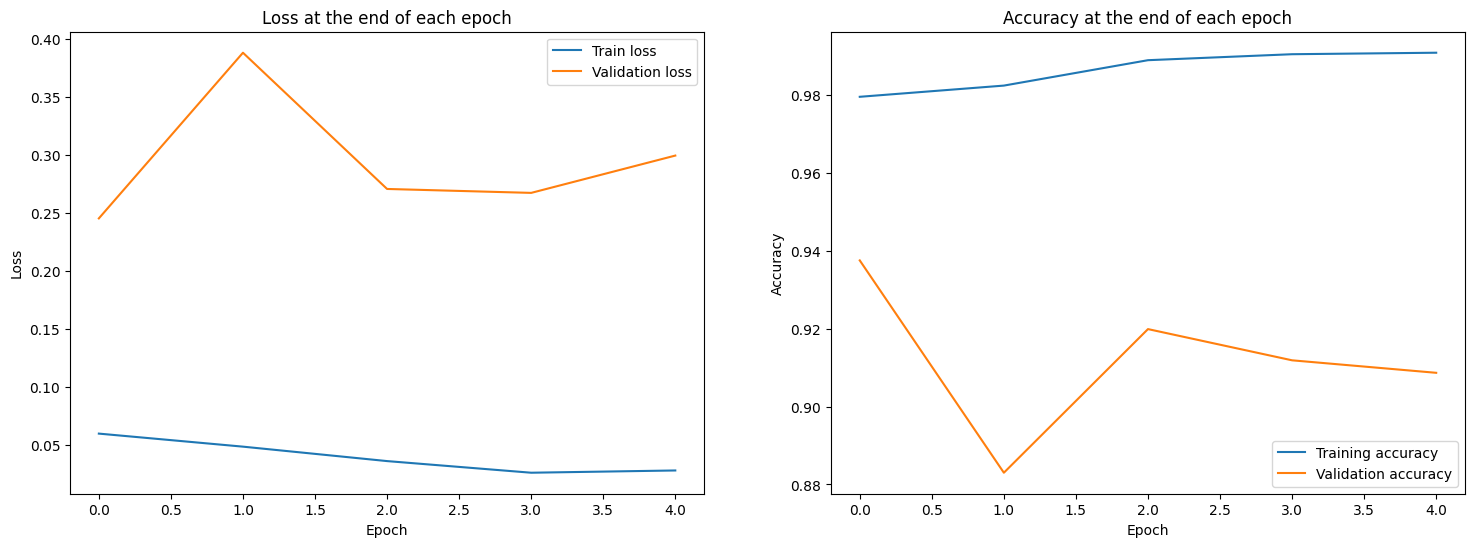

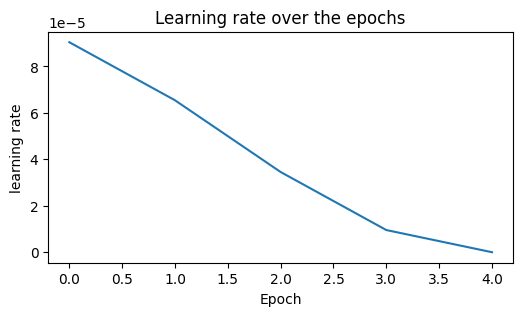

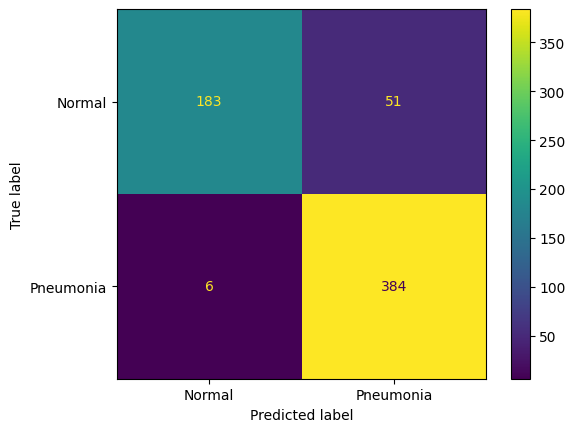

In [11]:
plot_learningcurve(metrics_history_efficientnet_final)

plot_learningrate(metrics_history_efficientnet_final['lrs'])

eval_metrics_efficientnet_final = evaluate_model(model_efficientnet_freeze, test_dataloader, loss_function, device="cpu")
       
print(f"Accuracy on the test set: {eval_metrics_efficientnet_final['accuracy']:.2%}")

print(f"Precision: {eval_metrics_efficientnet_final['precision']:.2f}, Recall: {eval_metrics_efficientnet_final['recall']:.2f}, F1 score: {eval_metrics_efficientnet_final['f1']:.2f}, AUC: {eval_metrics_efficientnet_final['auc']:.2f}")

print(f'classification_report :{eval_metrics_efficientnet_final['classification report']}')


# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics_efficientnet_final['confusion matrix'])